In [4]:
import imutils
import cv2

def load_image_rotate(image_path, angle):
    img = cv2.imread(image_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return imutils.rotate_bound(image, angle)

In [5]:
from utils import load_image, visualize_image

left = load_image('uttower_left.jpg')
right = load_image('uttower_right.jpg')
right_rotate_45 = load_image_rotate('uttower_right.jpg', 45)
right_rotate_5 = load_image_rotate('uttower_right.jpg', 5)

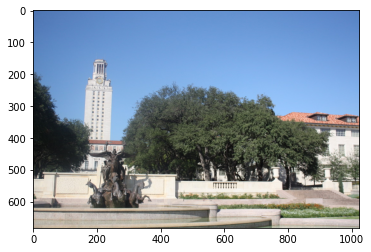

In [6]:
visualize_image(left)

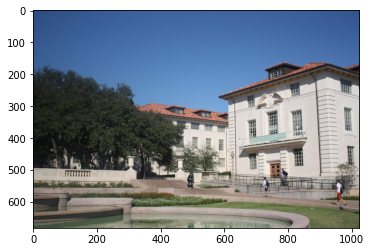

In [7]:
visualize_image(right)

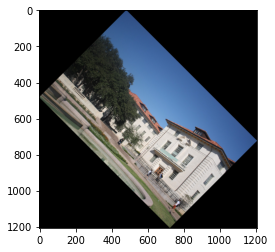

In [8]:
visualize_image(right_rotate_45)

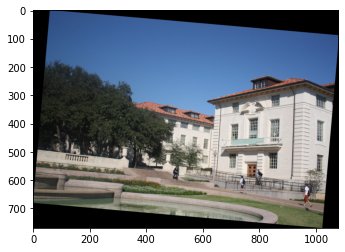

In [9]:
visualize_image(right_rotate_5)

# Feature Detection

In [10]:
from harris import Harris
from hessian import Hessian
from feature_detector import FeatureDetector
from utils import visualize_keypoints
from utils import load_keypoints, save_keypoints

In [11]:
harris = Harris()
feature_detector = FeatureDetector(harris)

In [12]:
try:
    left_keypoints = load_keypoints('results/left_keypoints.json')    
except:
    print('No saved keypoints found')
    left_keypoints = feature_detector(left, threshold=.07)
    save_keypoints(left_keypoints, 'results/left_keypoints.json')

In [13]:
try:
    right_keypoints = load_keypoints('results/right_keypoints.json')
    
except:
    print('No saved keypoints found')
    right_keypoints = feature_detector(right, threshold=.07)    
    save_keypoints(right_keypoints, 'results/right_keypoints.json')

In [14]:
try:
    right_rotate_keypoints_45 = load_keypoints('results/right_rotate_keypoints_45.json')
except:
    print('No saved keypoints found')
    right_rotate_keypoints_45 = feature_detector(right_rotate_45, threshold=.07)    
    save_keypoints(right_rotate_keypoints_45, 'results/right_rotate_keypoints_45.json')

In [15]:
try:
    right_rotate_keypoints_5 = load_keypoints('results/right_rotate_keypoints_5.json')
except:
    print('No saved keypoints found')
    right_rotate_keypoints_5 = feature_detector(right_rotate_5, threshold=.07)    
    save_keypoints(right_rotate_keypoints_5, 'results/right_rotate_keypoints_5.json')

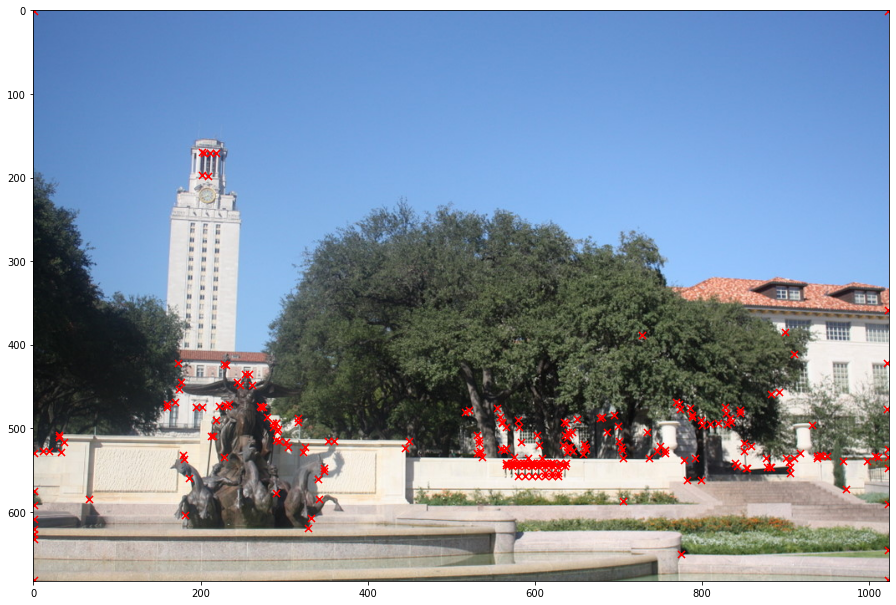

In [16]:
visualize_keypoints(left, left_keypoints)

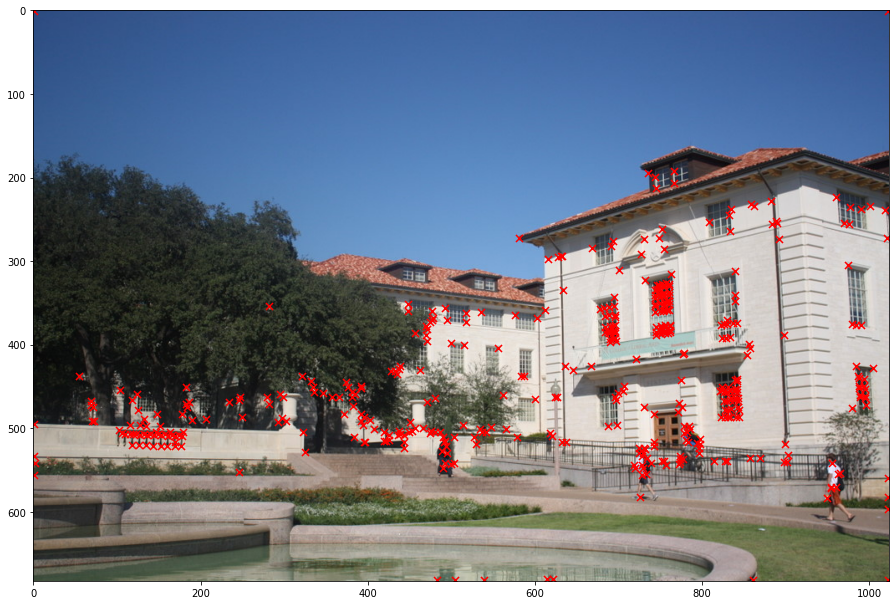

In [17]:
visualize_keypoints(right, right_keypoints)

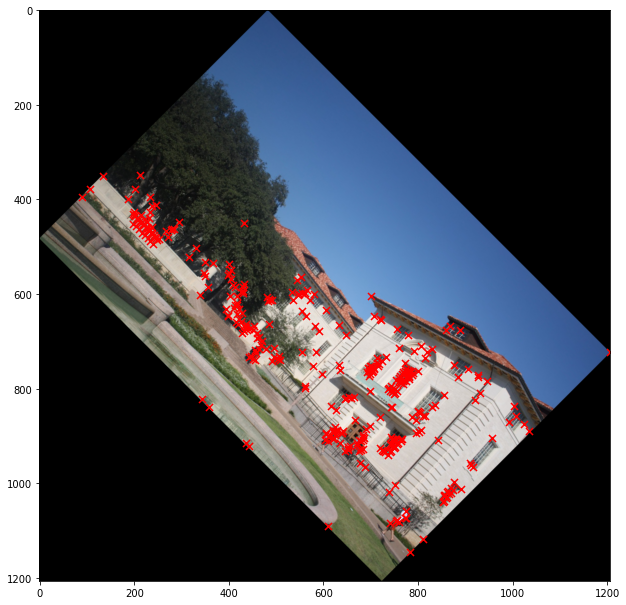

In [18]:
visualize_keypoints(right_rotate_45, right_rotate_keypoints_45)

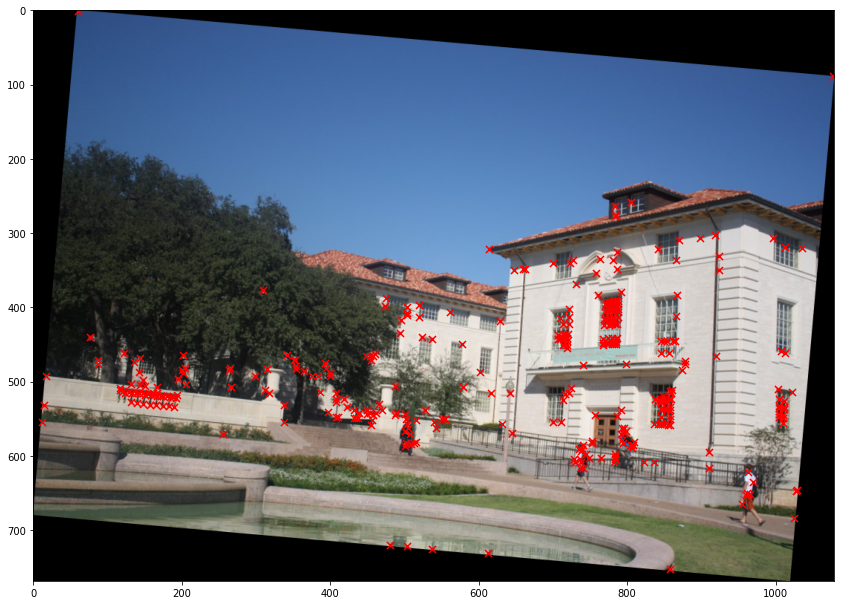

In [19]:
visualize_keypoints(right_rotate_5, right_rotate_keypoints_5)

# Feature Matching

## NCC

In [20]:
from feature_pairer import FeaturePairer
pairer = FeaturePairer(window_size=21, similarity='ncc')

In [21]:
ncc_pairs = pairer(left, left_keypoints, right, right_keypoints)
ncc_pairs_rotate_45 = pairer(left, left_keypoints, right_rotate_45, right_rotate_keypoints_45)
ncc_pairs_rotate_5 = pairer(left, left_keypoints, right_rotate_5, right_rotate_keypoints_5)

### Top 20 Pairs

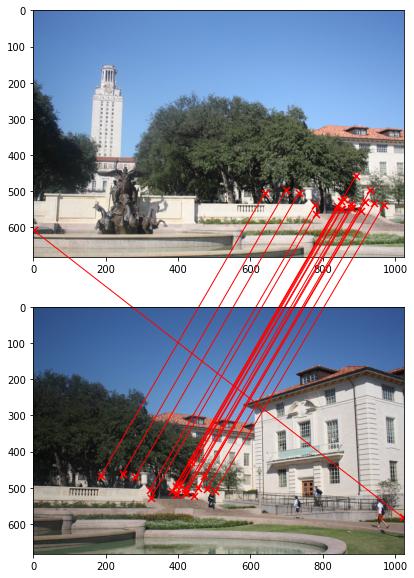

In [22]:
from utils import draw_matches
draw_matches(left, right, list(ncc_pairs.keys())[:20], set_inches=(10,10))

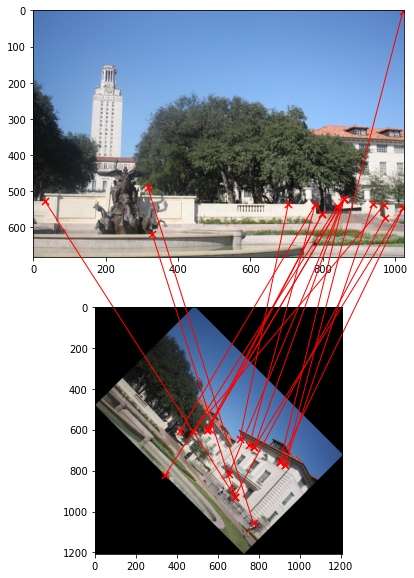

In [23]:
draw_matches(left, right_rotate_45, list(ncc_pairs_rotate_45.keys())[:20], set_inches=(10,10))

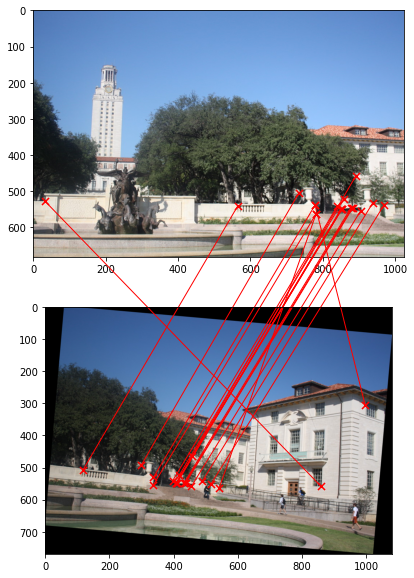

In [24]:
draw_matches(left, right_rotate_5, list(ncc_pairs_rotate_5.keys())[:20], set_inches=(10,10))

In [25]:
from utils import save_pairs
save_pairs(ncc_pairs, 'results/ncc_pairs.json')
save_pairs(ncc_pairs_rotate_45, 'results/ncc_pairs_rotate_45.json')
save_pairs(ncc_pairs_rotate_5, 'results/ncc_pairs_rotate_5.json')

## SSD

In [26]:
from feature_pairer import FeaturePairer
pairer = FeaturePairer(window_size=11, similarity='ssd')

In [31]:
ssd_pairs = pairer(left, left_keypoints, right, right_keypoints)
ssd_pairs_rotate_45 = pairer(left, left_keypoints, right_rotate_45, right_rotate_keypoints_45)
ssd_pairs_rotate_5 = pairer(left, left_keypoints, right_rotate_5, right_rotate_keypoints_5)

### Top 20 Pairs

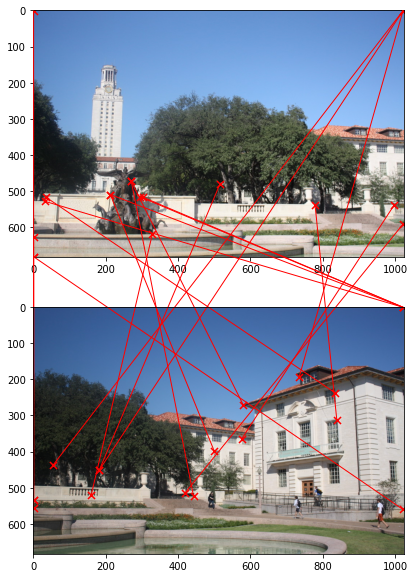

In [32]:
from utils import draw_matches
draw_matches(left, right, list(ssd_pairs.keys())[:20], set_inches=(10,10))

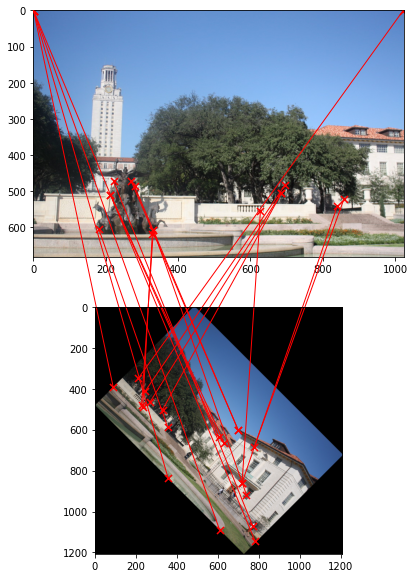

In [33]:
from utils import draw_matches
draw_matches(left, right_rotate_45, list(ssd_pairs_rotate_45.keys())[:20], set_inches=(10,10))

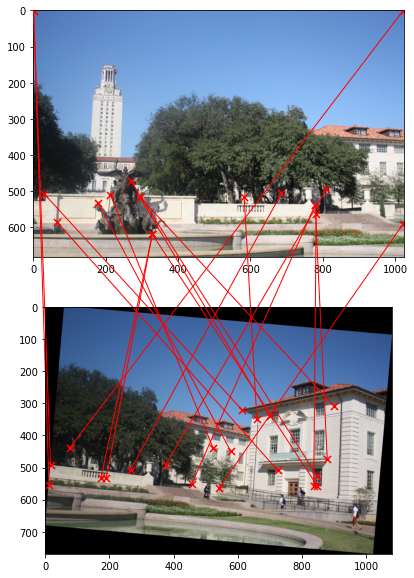

In [34]:
draw_matches(left, right_rotate_5, list(ssd_pairs_rotate_5.keys())[:20], set_inches=(10,10))

In [35]:
from utils import save_pairs
save_pairs(ssd_pairs, 'results/ssd_pairs.json')
save_pairs(ssd_pairs_rotate_45, 'results/ssd_pairs_rotate_45.json')
save_pairs(ssd_pairs_rotate_5, 'results/ssd_pairs_rotate_5.json')

# Conclusion

We have observed from the above three results that after rotating one of the image ncc doesnt give good results, as observed in 45 degree rotation but when rotated for a small degree the results are almost good as the original one as observed in 5 degree rotation.

This happened because after rotation the image and the patch which we match in ncc gets rotated and since in ncc we do pixel by pixel matching it wont yield good results. 

Also We can observe from the above results that NCC is more precise than SSD but computationally more expensive.

## Solution for rotation

We will need better feature descriptors than just a patch. SIFT descriptors will probably be a better choice. We can get eigenvector information in SIFT, with which we can get the principal orientation of the feature. Using that we can make adjustments to that portion of the image accordingly and then perform feature matching using NCC.